<a href="https://colab.research.google.com/github/PeterRoumeliotis/AIFireSmokeDetectionResearchProject/blob/main/AIFireAndSmokeDetectionResearch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Peter Roumeliotis**

In [2]:
import os
import shutil
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Dense, Dropout, Input
import cv2
import numpy as np
import time
import kagglehub
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Downloading latest version of the dataset I am using
path = kagglehub.dataset_download("phylake1337/fire-dataset")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fire-dataset


In [4]:
random.seed(42)

# Getting the source paths
source_dir = '/kaggle/input/fire-dataset/fire_dataset'
source_fire_dir = os.path.join(source_dir, 'fire_images')
source_non_fire_dir = os.path.join(source_dir, 'non_fire_images')

# Creating training and validation paths
dest_dir = 'data'
train_fire_dir = os.path.join(dest_dir, 'train', 'fire')
val_fire_dir = os.path.join(dest_dir, 'validation', 'fire')
train_non_fire_dir = os.path.join(dest_dir, 'train', 'non_fire')
val_non_fire_dir = os.path.join(dest_dir, 'validation', 'non_fire')

# Making sure the directories exist and if they dont, making them
os.makedirs(train_fire_dir, exist_ok=True)
os.makedirs(val_fire_dir, exist_ok=True)
os.makedirs(train_non_fire_dir, exist_ok=True)
os.makedirs(val_non_fire_dir, exist_ok=True)

# 80% training 20% validation
split_ratio = 0.8

# Splitting the files into each folder
def split_data(source_folder, train_folder, val_folder, split_ratio=0.8):

    # List all items in source folder and keep only files
    file_list = [f for f in os.listdir(source_folder) if os.path.isfile(os.path.join(source_folder, f))]
    # Randomizes it
    random.shuffle(file_list)

    # Figures out at what index to split the files
    split_point = int(len(file_list) * split_ratio)
    train_files = file_list[:split_point]   # Training
    val_files = file_list[split_point:]   # Validation

    # Copying files into training
    for file_name in train_files:
        src = os.path.join(source_folder, file_name)
        dst = os.path.join(train_folder, file_name)
        shutil.copy(src, dst)

    # Copying files into validation
    for file_name in val_files:
        src = os.path.join(source_folder, file_name)
        dst = os.path.join(val_folder, file_name)
        shutil.copy(src, dst)

split_data(source_fire_dir, train_fire_dir, val_fire_dir, split_ratio)
split_data(source_non_fire_dir, train_non_fire_dir, val_non_fire_dir, split_ratio)

print("Data is split")

Data is split


In [5]:
img_width, img_height = 150, 150

batch_size = 32
epochs = 20

train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# Augmenting training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Rescaling validation data
validation_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

# Generate validation batches
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary'
)

Found 799 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# My Model

In [6]:
from tensorflow.keras.optimizers import Adam
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [7]:
history = model.fit(train_generator, steps_per_epoch=train_generator.samples, epochs=epochs, validation_data=validation_generator, validation_steps=validation_generator.samples // batch_size)

model_save_path = "fire_detection_cnn.keras"
model_googledrive_path = "/content/drive/MyDrive/fire_detection_cnn.keras"
model.save(model_googledrive_path)
model.save(model_save_path)
print(f"Model saved to {model_save_path} and {model_googledrive_path}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
 25/799 ━━━━━━━━━━━━━━━━━━━━ 12:05 937ms/step - accuracy: 0.7634 - loss: 0.5274

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


799/799 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.8507 - loss: 0.3727 - val_accuracy: 0.9010 - val_loss: 0.6345
Epoch 2/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 24s 25ms/step - accuracy: 0.9087 - loss: 0.2213 - val_accuracy: 0.8542 - val_loss: 0.5421
Epoch 3/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 20s 24ms/step - accuracy: 0.9168 - loss: 0.1983 - val_accuracy: 0.9062 - val_loss: 0.5307
Epoch 4/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 21s 25ms/step - accuracy: 0.9339 - loss: 0.1577 - val_accuracy: 0.8698 - val_loss: 0.4677
Epoch 5/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9216 - loss: 0.1848 - val_accuracy: 0.9115 - val_loss: 0.4077
Epoch 6/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 21s 26ms/step - accuracy: 0.9438 - loss: 0.1543 - val_accuracy: 0.7969 - val_loss: 0.3883
Epoch 7/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.9349 - loss: 0.1518 - val_accuracy: 0.8333 - val_loss: 0.3713
Epoch 8/20
799/799 ━━━━━━━━━━━━━━━━━━━━ 21s 24ms/step - accuracy: 0.9413 - loss: 0.1565 - val_accurac

In [8]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 127.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.5 MB/s eta 0:00:00


In [9]:
import os

# https://blog.roboflow.com/how-to-train-yolov8-on-a-custom-dataset/
# https://www.digitalocean.com/community/tutorials/train-yolov5-custom-data
# Sources I used to help me format my dataset for yolo

for split in ["train","validation"]:
    for cls_idx, cls in enumerate(["non_fire","fire"]):
        folder = f"data/{split}/{cls}"
        for img in os.listdir(folder):
            # Skips non images
            if not img.lower().endswith((".jpg",".png")): continue
            img_path   = os.path.join(folder, img)
            label_path = os.path.splitext(img_path)[0] + ".txt"

            if cls == "fire":
                with open(label_path, "w") as f:
                    # Formats data for yolo
                    f.write(f"{1} 0.5 0.5 1.0 1.0\n")
            else:
                open(label_path, "w").close()


In [10]:
# Making YAML for yolo

# https://docs.ultralytics.com/
# https://docs.ultralytics.com/yolov5/tutorials/train_custom_data/

# Used these sources for help

%%bash
cat <<EOF > data/fire_data.yaml
train: /content/data/train
val:   /content/data/validation

names:
  0: non_fire
  1: fire
EOF

echo "Created YAML:"
cat data/fire_data.yaml


Created YAML:
train: /content/data/train
val:   /content/data/validation

names:
  0: non_fire
  1: fire


In [11]:
from ultralytics import YOLO

yolo = YOLO('yolov8n.pt')

yolo.train(
    data='data/fire_data.yaml',
    epochs=20,
    imgsz=150,
    batch=32,
    project='yolo-fire',
    name='exp'
)

yolo_model = YOLO('yolo-fire/exp/weights/best.pt')
yolo_model.save('/content/drive/MyDrive/best.pt')


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 6.25M/6.25M [00:00<00:00, 404MB/s]


Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data/fire_data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=150, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

100%|██████████| 755k/755k [00:00<00:00, 84.4MB/s]

Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,011,238 parameters, 3,011,222 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 360MB/s]


AMP: checks passed ✅
WARNING ⚠️ imgsz=[150] must be multiple of max stride 32, updating to [160]
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1299.1±1079.6 MB/s, size: 66.6 KB)


train: Scanning /content/data/train/fire... 798 images, 194 backgrounds, 1 corrupt: 100%|██████████| 799/799 [00:00<00:00, 1103.00it/s]

train: /content/data/train/fire/fire.357.png: corrupt JPEG restored and saved
train: /content/data/train/fire/fire.576.png: corrupt JPEG restored and saved
train: /content/data/train/fire/fire.681.png: corrupt JPEG restored and saved
train: /content/data/train/non_fire/non_fire.189.png: ignoring corrupt image/label: invalid image format GIF. Supported formats are:
images: {'png', 'jpg', 'mpo', 'bmp', 'dng', 'jpeg', 'heic', 'tiff', 'pfm', 'tif', 'webp'}
videos: {'asf', 'webm', 'mpeg', 'mpg', 'mov', 'ts', 'mp4', 'wmv', 'mkv', 'm4v', 'avi', 'gif'}


train: New cache created: /content/data/train/fire.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 485.9±85.4 MB/s, size: 299.9 KB)


val: Scanning /content/data/validation/fire... 200 images, 49 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<00:00, 1227.80it/s]

val: New cache created: /content/data/validation/fire.cache


Plotting labels to yolo-fire/exp/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 160 train, 160 val
Using 2 dataloader workers
Logging results to yolo-fire/exp
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.346G     0.7383      2.439      1.165         70        160: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.39s/it]

                   all        200        151      0.874      0.919      0.963      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.363G      0.415     0.7979     0.9826         74        160: 100%|██████████| 25/25 [00:12<00:00,  2.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.96it/s]

                   all        200        151      0.635      0.914      0.761      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.391G      0.369     0.6833     0.9576         70        160: 100%|██████████| 25/25 [00:13<00:00,  1.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        200        151      0.953      0.937      0.983      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.408G     0.3392     0.5962     0.9437         76        160: 100%|██████████| 25/25 [00:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.94it/s]

                   all        200        151      0.978      0.894       0.98      0.923



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.424G     0.3307     0.5787     0.9406         76        160: 100%|██████████| 25/25 [00:12<00:00,  1.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.09it/s]

                   all        200        151      0.898      0.818      0.912      0.859



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.441G     0.3022     0.5082     0.9244         79        160: 100%|██████████| 25/25 [00:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.41it/s]

                   all        200        151      0.982      0.921      0.982      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.459G     0.2992     0.4709     0.9234         75        160: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.78it/s]

                   all        200        151      0.969      0.817      0.927      0.913



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.477G     0.2694     0.4694       0.92         72        160: 100%|██████████| 25/25 [00:12<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.33it/s]

                   all        200        151      0.905      0.885      0.949      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.492G     0.2557     0.4373     0.9088         69        160: 100%|██████████| 25/25 [00:12<00:00,  2.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.17it/s]


                   all        200        151      0.914       0.96      0.972      0.951

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      0.51G     0.2366     0.4088     0.9052         74        160: 100%|██████████| 25/25 [00:12<00:00,  1.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        200        151      0.912      0.934      0.958      0.947


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.525G     0.2273     0.6916     0.8797         28        160: 100%|██████████| 25/25 [00:15<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.35it/s]

                   all        200        151      0.864      0.927      0.869      0.869



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.543G     0.1914     0.3964     0.8642         20        160: 100%|██████████| 25/25 [00:12<00:00,  2.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.25it/s]

                   all        200        151      0.987      0.993      0.991      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.561G     0.1663     0.3085     0.8471         23        160: 100%|██████████| 25/25 [00:12<00:00,  2.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.15it/s]

                   all        200        151      0.973          1      0.994      0.993



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.578G     0.1517     0.2911     0.8601         24        160: 100%|██████████| 25/25 [00:13<00:00,  1.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.59it/s]


                   all        200        151      0.982      0.993      0.993       0.99

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.594G       0.13     0.2557     0.8466         22        160: 100%|██████████| 25/25 [00:11<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]

                   all        200        151      0.993      0.987      0.994      0.994



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.611G     0.1221     0.2316     0.8498         22        160: 100%|██████████| 25/25 [00:13<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.93it/s]

                   all        200        151      0.993      0.993      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.627G     0.1173     0.2191     0.8409         24        160: 100%|██████████| 25/25 [00:12<00:00,  1.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.67it/s]

                   all        200        151      0.992      0.987      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.645G     0.1013      0.193     0.8465         25        160: 100%|██████████| 25/25 [00:12<00:00,  2.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.71it/s]


                   all        200        151      0.993      0.993      0.995      0.992

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.662G    0.09611     0.1787     0.8522         21        160: 100%|██████████| 25/25 [00:13<00:00,  1.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.37it/s]

                   all        200        151      0.993      0.993      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      0.68G    0.09009     0.1858     0.8338         27        160: 100%|██████████| 25/25 [00:10<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.63it/s]


                   all        200        151      0.993      0.993      0.994      0.994

20 epochs completed in 0.089 hours.
Optimizer stripped from yolo-fire/exp/weights/last.pt, 6.2MB
Optimizer stripped from yolo-fire/exp/weights/best.pt, 6.2MB

Validating yolo-fire/exp/weights/best.pt...
Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<00:00,  2.06it/s]


                   all        200        151      0.993      0.993      0.995      0.995
                  fire        151        151      0.993      0.993      0.995      0.995
Speed: 0.0ms preprocess, 0.8ms inference, 0.0ms loss, 3.0ms postprocess per image
Results saved to yolo-fire/exp


In [12]:
cnn_model = tf.keras.models.load_model('fire_detection_cnn.keras')
yolo_model = YOLO('yolo-fire/exp/weights/best.pt')

# Upload/open vid
uploaded = files.upload()
video_path = next(iter(uploaded.keys()))
print(f"Video file: {video_path}")
cap = cv2.VideoCapture(video_path)

# Frames per second, default is 30
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0

frame_indices = []  # Frame numbers
cnn_flags     = []  # My model
yolo_flags    = []  # Yolo

frame_idx = 0

# Loop through vid by frame
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_idx += 1

    # My model detection
    # Resize/normalize
    img = cv2.resize(frame, (150,150)) / 255.0
    # Get the fire probability from my model
    p = cnn_model.predict(np.expand_dims(img,0), verbose=0)[0][0]
    # Detect if probability > 0.5
    cnn_detected = (p > 0.5)

    # YOLO detection
    # Run yolo
    res = yolo_model(frame, verbose=False)[0]
    classes = res.boxes.cls.cpu().numpy().astype(int).tolist()
    # Detect if there is class 1 (fire)
    yolo_detected = (1 in classes)

    # Results
    frame_indices.append(frame_idx)
    cnn_flags.append(cnn_detected)
    yolo_flags.append(yolo_detected)

cap.release()


Saving Yosemite Forest Fire Time Lapse and Flyover.mp4 to Yosemite Forest Fire Time Lapse and Flyover.mp4
Video file: Yosemite Forest Fire Time Lapse and Flyover.mp4


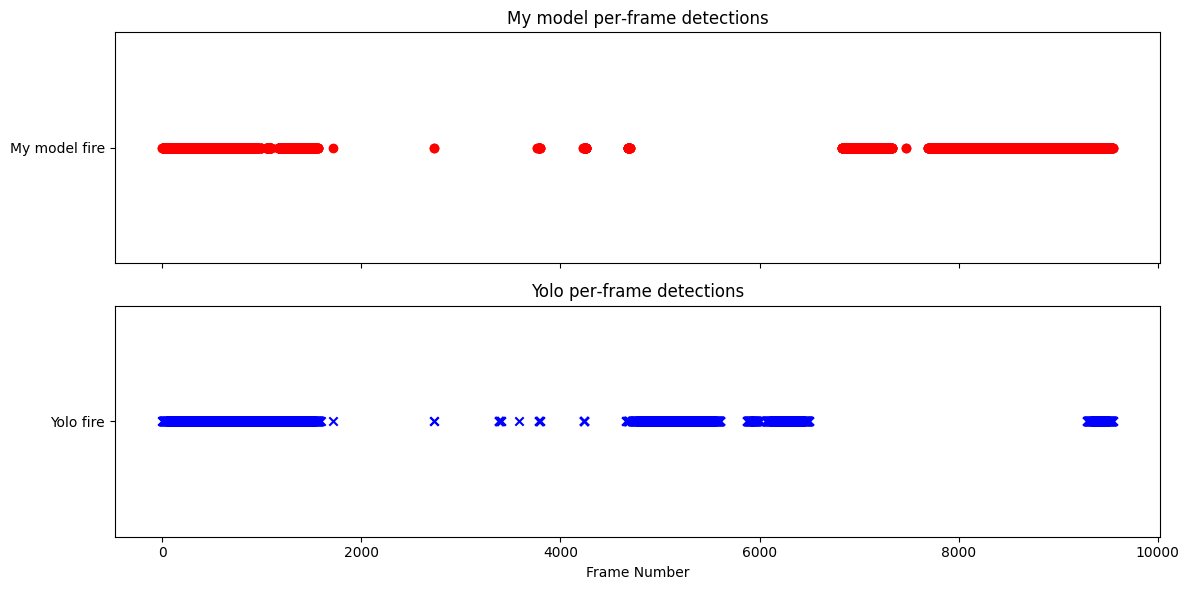

In [13]:
# Plotting results
import matplotlib.pyplot as plt

cnn_frames = [frame_indices[i] for i, flag in enumerate(cnn_flags) if flag]
yolo_frames = [frame_indices[i] for i, flag in enumerate(yolo_flags) if flag]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# My model detections (red circles)
ax1.scatter(cnn_frames, [1]*len(cnn_frames),
            label='My model detected', marker='o', c='red')
ax1.set_yticks([1])
ax1.set_yticklabels(['My model fire'])
ax1.set_title('My model per‐frame detections')

# Yolo detections (blue X’s)
ax2.scatter(yolo_frames, [1]*len(yolo_frames),
            label='Yolo detected', marker='x', c='blue')
ax2.set_yticks([1])
ax2.set_yticklabels(['Yolo fire'])
ax2.set_title('Yolo per‐frame detections')

ax2.set_xlabel('Frame Number')
plt.tight_layout()
plt.show()


In [24]:
# Referred to documentation to help teach me about all of this
# https://www.tensorflow.org/guide/keras/functional#convert_a_sequential_model_to_a_functional_model
# https://keras.io/examples/vision/grad_cam/
# https://docs.opencv.org/4.x/dd/d9e/classcv_1_1VideoWriter.html

sequential_model = load_model('fire_detection_cnn.keras')

# Using the last Conv2D layer
layer_name = 'conv2d_2'

# Building model to take frames of 150x150 that gets the activation of Conv2D and the prediction
inp = Input(shape=(150,150,3))
x = inp
conv_output = None
for layer in sequential_model.layers:
    x = layer(x)
    if layer.name == layer_name:
        conv_output = x
preds = x

# Making grad-CAM model
grad_model = Model(inputs=inp, outputs=[conv_output, preds])

# Upload video/open it
uploaded = files.upload()
video_path = next(iter(uploaded.keys()))
cap = cv2.VideoCapture(video_path)

# Frames per second
fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
# Width and height of frames
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# Needed to use codec to make file smaller in order to work and be able to store the video because it is too large
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
# Output w/ file name
out = cv2.VideoWriter('cnn_gradcam_output.mp4', fourcc, fps, (w, h))

# Loops through every frame
frame_count = 0
while True:
    ret, frame = cap.read()
    if not ret: break
    frame_count += 1

    # Preprocessing
    # Resize/Normalize
    small = cv2.resize(frame, (150,150)) / 255.0
    # Add batch dimension
    inp_arr = np.expand_dims(small, 0).astype(np.float32)

    with tf.GradientTape() as tape:
        # Recording sensor readings/fire probability
        conv_maps, pred = grad_model(inp_arr)
        # Watches them (Sees how changing maps affects the final score)
        tape.watch(conv_maps)
        # Loss is fire prob
        loss = pred[:,0]
    # Computes Gradient
    grads = tape.gradient(loss, conv_maps)

    # Building CAM
    weights = tf.reduce_mean(grads, axis=(0,1,2))
    cam = tf.reduce_sum(conv_maps[0] * weights, axis=-1)

    # Normalize CAM, wanting to make sure it is between 0 and 1 so its not negative number
    cam = tf.maximum(cam, 0)
    max_val = tf.reduce_max(cam)
    if max_val > 0:
        cam = cam / max_val
    else:
        cam = tf.zeros_like(cam)
    score = float(pred[0][0])

    # Overlay heatmap when model detects fire (greater than 50%)
    if score > 0.5:
        heat = (cam.numpy()*255).astype(np.uint8)
        heat = cv2.resize(heat, (w, h))
        heat = cv2.applyColorMap(heat, cv2.COLORMAP_HOT)
        frame = cv2.addWeighted(frame, 0.6, heat, 0.4, 0)

    # Annotate and write to the frames
    color = (0,0,255) if score>0.7 else (255,0,0)
    cv2.putText(frame, f"Fire: {score:.2f}", (10,30),
                cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)
    out.write(frame)

cap.release()
out.release()

print(f"Processed {frame_count} frames and saved as cnn_gradcam_output.mp4")

drive.mount('/content/drive')
shutil.copy('cnn_gradcam_output.mp4', '/content/drive/MyDrive/cnn_gradcam_output.mp4')
print("Also saved to Google Drive at MyDrive/cnn_gradcam_output.mp4")

Saving Yosemite Forest Fire Time Lapse and Flyover.mp4 to Yosemite Forest Fire Time Lapse and Flyover (6).mp4
Processed 9548 frames and saved as cnn_gradcam_output.mp4
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Also saved to Google Drive at MyDrive/cnn_gradcam_output.mp4
